# LDA
Modelamiento de Tópicos con LDA (Latent Dirichet Allocation) para categorías de la base Barómetro Migrante

# Procesamiento de texto a través spaCy
Si usted no posee una GPU, no intente correr ninguno de los paquetes que se instalan por !pip. Se le hará una lista de requisitos y formas para correr con exito spaCy desde una GPU con arquitectura Turing:
 1. Instale la versión y el paquete de spaCy en Español para procesar texto en este lenguaje
 2. La versión de CUDA es 11.0, válido para GPUs NVIDIA con versión cuDNN 8.0+. Esto lo necesita su equipo para asignar la memoria a la tarjeta gráfica. Se instala por fuera de Python [CUDA](https://developer.nvidia.com/cuda-downloads).
 3. Instale la versión de Pytorch compatible con su versión de CUDA, recuerde que spaCy tiene transformers, esto tiene que estar especificado para que descargue los paquetes de clasificación
 4. Thinc GPU OPS y CuPy son necesarios para que el equipo reconozca la tarjeta gráfica y la vuelva accesible desde Jupyter.
 
Con esto podrá iniciar a correr modelos complejos en su equipo de trabajo, recuerde que no debe de correr ninguna línea que instale un paquete.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
'''
!pip install lda2vec
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis
!pip install tensorflow
!pip install keras
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda110,transformers,lookups]
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm
!python -m spacy download es_dep_news_trf
!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user
!pip install cupy-cuda110
!pip install thinc-gpu-ops
!pip install gensim
!pip install -q wordcloud
!python --version
!pip install --upgrade gensim
!pip install spacy_spanish_lemmatizer
!python -m spacy_spanish_lemmatizer download wiki
!pip install python-Levenshtein
'''

'\n!pip install lda2vec\n!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis\n!pip install tensorflow\n!pip install keras\n!pip install -U pip setuptools wheel\n!pip install -U spacy[cuda110,transformers,lookups]\n!python -m spacy download es_core_news_sm\n!python -m spacy download en_core_web_sm\n!python -m spacy download es_dep_news_trf\n!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --user\n!pip install cupy-cuda110\n!pip install thinc-gpu-ops\n!pip install gensim\n!pip install -q wordcloud\n!python --version\n!pip install --upgrade gensim\n!pip install spacy_spanish_lemmatizer\n!python -m spacy_spanish_lemmatizer download wiki\n!pip install python-Levenshtein\n'

In [2]:
#Espacio de trabajo
import tqdm
import numpy as np
from numpy.random import seed
from numpy.random import randint
#import lda2vec as l2v
import gensim
from gensim import corpora, similarities, models
from gensim.models.phrases import Phraser
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import seaborn
except:
    pass
import sys
import pandas as pd
import spacy
from spacy_spanish_lemmatizer import SpacyCustomLemmatizer
import wordcloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import re
import logging
import pyLDAvis
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

C:\Users\JOSE\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps

In [3]:
base_entera = pd.read_excel('Guatemala_Xenofobia.xlsx')
base_entera

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags
0,01-Apr-2021 09:58PM,NaN,https://twitter.com/denunciasNicar2/statuses/1...,NaN,QT @denunciasNicar2: RT @MNAutoconvocado: Ento...,Twitter,denunciasnicar2,Guatemala,NaN,Spanish / Castilian,...,denunciasNicaragua,https://twitter.com/denunciasNicar2,It is a page to denounce the abuses of this Ge...,1394.0,4900.0,"Apr 1, 2021",21:58:00,NaN,NaN,NaN
1,01-Apr-2021 09:57PM,NaN,https://twitter.com/denunciasNicar2/statuses/1...,NaN,QT @denunciasNicar2: RT @denunciasNicar2: @Don...,Twitter,denunciasnicar2,Guatemala,NaN,Spanish / Castilian,...,denunciasNicaragua,https://twitter.com/denunciasNicar2,It is a page to denounce the abuses of this Ge...,1394.0,4900.0,"Apr 1, 2021",21:57:00,NaN,NaN,NaN
2,01-Apr-2021 06:17PM,NaN,https://twitter.com/DeSigaran/statuses/1377761...,NaN,@CarmenElenaAFC Por pendejadas diría yo... Bie...,Twitter,desigaran,Guatemala,NaN,Spanish / Castilian,...,Nestor de León,https://twitter.com/DeSigaran,Ing. de redes y telecomunicaciones.,60.0,231.0,"Apr 1, 2021",18:17:00,NaN,NaN,NaN
3,01-Apr-2021 10:46AM,NaN,https://twitter.com/profmacaca/statuses/137764...,NaN,"RT @Cmontoya64: Mientras Simón Bolívar, un ven...",Twitter,profmacaca,Guatemala,NaN,Spanish / Castilian,...,Carmen,https://twitter.com/profmacaca,Chavista Magallanera Amante de lo bello sencil...,710.0,703.0,"Apr 1, 2021",10:46:00,Escuintla,Santa Lucía Cotzumalguapa,NaN
4,01-Apr-2021 10:12AM,NaN,https://twitter.com/Edwingpmez/statuses/137763...,NaN,RT @versatilcali4: El venezolano Despues de sa...,Twitter,edwingpmez,Guatemala,NaN,Spanish / Castilian,...,Edwin Gomez,https://twitter.com/Edwingpmez,NaN,151.0,1178.0,"Apr 1, 2021",10:12:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,17-Apr-2020 10:33PM,NaN,https://twitter.com/Dax_Artiga22/statuses/1251...,NaN,@FunesCartagena Regresa los millones robados y...,Twitter,dax_artiga22,Guatemala,NaN,Spanish / Castilian,...,Dax Artiga,https://twitter.com/Dax_Artiga22,"Aficionado a los deportes mis equipos, AGUILA,...",105.0,475.0,"Apr 17, 2020",22:33:00,San Marcos,San Marcos,NaN
2720,17-Apr-2020 08:51PM,NaN,http://twitter.com/NapoleonCampos/statuses/125...,NaN,RT @confidencial_ni: #EstaSemana | El Banco Mu...,Twitter,napoleoncampos,Guatemala,NaN,Spanish / Castilian,...,Napoleon Campos,https://twitter.com/NapoleonCampos,Especialista salvadoreño/centroamericano en Te...,2191.0,898.0,"Apr 17, 2020",20:51:00,Guatemala,Guatemala City,NaN
2721,17-Apr-2020 06:41PM,NaN,https://twitter.com/JosRodr18317588/statuses/1...,NaN,QT @Mippcivzla: ⏭️ #AtenciónMédicaDeCalidad 💛@...,Twitter,josrodr18317588,Guatemala,NaN,Spanish / Castilian,...,José Rodríguez 😎📲💻,https://twitter.com/JosRodr18317588,Dios te bendiga...🙏😇\nVenezuela 🇻🇪💛💙❤️,2872.0,1282.0,"Apr 17, 2020",18:41:00,Sacatepéquez,Santa María de Jesús,NaN
2722,17-Apr-2020 11:54AM,NaN,https://twitter.com/raularmando10/statuses/125...,NaN,"@IsaacHMH Como no veo televisión salvadoreña, ...",Twitter,raularmando10,Guatemala,NaN,Spanish / Castilian,...,Armond Schz,https://twitter.com/raularmando10,"Naci el 19 de Agosto de 1972, en la Ciudad de ...",9.0,104.0,"Apr 17, 2020",11:54:00,San Marcos,San Miguel Ixtahuacán,NaN


In [4]:
#df = base_entera[base_entera['Xenofobia'] == 1]
df = base_entera
# Remover el QT y el RTs por contexto
def meltwater_QT_and_RT_remover(df):
    df['RT'] = df['Hit Sentence'].astype(str).str.find('RT')
    df['QT'] = df['Hit Sentence'].astype(str).str.find('QT')
    # Remove authors
    df['Snippet'] = df['Hit Sentence'].replace(r'@\w+', '', regex=True)
    # Manejar QT con RT
    'QT @author: ... RT @author2: ...'
    df.loc[(df['RT'] != -1) & (df['QT'] != -1), 'Snippet'] = df['Snippet'].str.extract(r'QT(.*)RT')[0]
    # Manejar QT sin RT
    'QT @author: ...'
    df.loc[(df['RT'] == -1) & (df['QT'] != -1), 'Snippet'] = df['Snippet'].str.extract(r'QT(.*)\;')[0]
    # Manejar RT sin QT
    'RT @author: ...'
    df.loc[(df['RT'] != -1) & (df['QT'] == -1), 'Snippet'] = df['Snippet'].replace(r'[RT].*$', '', regex = True)
    df['Snippet'] = df['Snippet'].replace(r'\:', '', regex=True)
    df['Snippet'] = df['Snippet'].replace("", np.nan)
    df['Snippet'] = df['Snippet'].replace('  ', np.nan)
    print(df[['QT','RT','Hit Sentence','Snippet']].head(25))
    df = df.dropna(subset=['Snippet'])
    df = df.drop(columns=['RT', 'QT'])
    return df
df = meltwater_QT_and_RT_remover(df)

    QT  RT                                       Hit Sentence  \
0    0  21  QT @denunciasNicar2: RT @MNAutoconvocado: Ento...   
1    0  21  QT @denunciasNicar2: RT @denunciasNicar2: @Don...   
2   -1  -1  @CarmenElenaAFC Por pendejadas diría yo... Bie...   
3   -1   0  RT @Cmontoya64: Mientras Simón Bolívar, un ven...   
4   -1   0  RT @versatilcali4: El venezolano Despues de sa...   
5    0  19  QT @jesuscasique1: RT @JMilei: La maravilla de...   
6   -1   0  RT @Marco_Teruggi: La campaña sucia de Lasso/D...   
7    0  12  QT @CEPASV: RT @nayibbukele: Sigue la campaña ...   
8   -1  -1  @jfromerom ...empleos perdidos, los pobres más...   
9   -1  -1  Todavía hay pendejos discutiendo la venezolane...   
10  -1   0  RT @traffiCARACAS: #30Mar 🙏 #Vzla José Gregori...   
11   0  16  QT @piensosoyo: RT @PJeamali: Y los simpatizan...   
12   0  19  QT @RonyVillachen: RT @juanlumonte: ¿ Cuba, Ve...   
13  -1   0  RT @CarlosEAvendao3: ES INAUDITO GUATE. que Tú...   
14  -1   0  RT @arturobar

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
seed(1)
values = list(set(randint(0, 22255, 500)))

temp=df.loc[df.index.isin(values)]
print(len(temp))
del values

temp.head()

24


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet
42,25-Mar-2021 04:43PM,NaN,https://twitter.com/WalterGudiel/statuses/1375...,NaN,"Antes, los culpables de sus penas y desgracias...",Twitter,waltergudiel,Guatemala,NaN,Spanish / Castilian,...,https://twitter.com/WalterGudiel,"Abogado, amante de la democracia, la libertad,...",2688.0,2811.0,"Mar 25, 2021",16:43:00,NaN,NaN,NaN,"Antes, los culpables de sus penas y desgracias..."
144,01-Mar-2021 04:23PM,NaN,https://twitter.com/joma8875/statuses/13665143...,NaN,@LuisMiguelReyes Creo que el pueblo salvadoreñ...,Twitter,joma8875,Guatemala,NaN,Spanish / Castilian,...,https://twitter.com/joma8875,NaN,172.0,2469.0,"Mar 1, 2021",16:23:00,NaN,NaN,NaN,Creo que el pueblo salvadoreño merece respeto...
174,24-Feb-2021 11:29PM,NaN,http://twitter.com/alanrgd_/statuses/136480974...,NaN,QT @AlertaNews24: Sin ofender a nadie. PERO.. ...,Twitter,alanrgd_,Guatemala,NaN,Spanish / Castilian,...,http://www.twitter.com/alanrgd_,abogado ciego,358.0,677.0,"Feb 24, 2021",23:29:00,NaN,NaN,NaN,Sin ofender a nadie. PERO.. NICARAGUA NOS GA...
269,05-Feb-2021 01:06PM,NaN,http://twitter.com/vladimir7/statuses/13577674...,NaN,Puta ese 0te del moto si salido de la nica el ...,Twitter,vladimir7,Guatemala,NaN,Spanish / Castilian,...,http://www.twitter.com/vladimir7,"Tengo pendientes, asi que me los recuerdo a di...",165.0,317.0,"Feb 5, 2021",13:06:00,NaN,NaN,NaN,Puta ese 0te del moto si salido de la nica el ...
379,05-Jan-2021 06:54PM,NaN,https://twitter.com/juansical3/statuses/134662...,NaN,QT @JLFont001: Los capitalinos me discriminan ...,Twitter,juansical3,Guatemala,NaN,Spanish / Castilian,...,https://twitter.com/juansical3,Sincero y directo.,881.0,180.0,"Jan 5, 2021",18:54:00,NaN,NaN,NaN,Los capitalinos me discriminan por ser de Pe...


In [6]:
#Eliminamos los URL: Todo lo que empieza por  HTTP
df['Clean_Text']=df['Snippet'].replace(r"http\S+", '', regex=True)
#Eliminamos todos los hashtags
df['Clean_Text']=df['Clean_Text'].replace('#\\w+', '', regex=True)
#Eliminamos los signos de puntuación repetidos dentro de los tweets
df['Clean_Text']=df['Clean_Text'].replace(r'([^0-9a-zA-Z])\1+', r'\1', regex=True)
#Eliminamos los signos de puntuación al inicio de un tweet
df['Clean_Text']=df['Clean_Text'].replace(r'^[^0-9a-zA-Z@#]+', '', regex=True)
#Eliminamos los dobles espacios
df['Clean_Text']=df['Clean_Text'].replace(r'()\1+', r'\1\1', regex=True)
#Eliminamos las letras repetivas dentro de las palabras
df['Clean_Text']=df['Clean_Text'].replace(r'(.)\1+', r'\1\1', regex=True)
# Quitar las comillas de los textos
df['Clean_Text']=df['Clean_Text'].replace('"', '', regex=True)
# Remover puntuaciones innecesarias
df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remover mayúsculas de inicio de texto
df['Clean_Text'] = df['Clean_Text'].map(lambda x: x.lower())
df=df.reset_index(drop=True)
df=df.reset_index()
df = df.astype({"Clean_Text": str})
df.head(11)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:16: DeprecationWarning: invalid escape sequence \.
<>:16: DeprecationWarning: invalid escape sequence \.
<ipython-input-6-85578270f296>:16: DeprecationWarning: invalid escape sequence \.
  df['Clean_Text'] = df['Clean_Text'].map(lambda x: re.sub('[,\.!?]', '', x))


,index,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet,Clean_Text
0,0,01-Apr-2021 06:17PM,NaN,https://twitter.com/DeSigaran/statuses/1377761...,NaN,@CarmenElenaAFC Por pendejadas diría yo... Bie...,Twitter,desigaran,Guatemala,NaN,...,Ing. de redes y telecomunicaciones.,60.0,231.0,"Apr 1, 2021",18:17:00,NaN,NaN,NaN,Por pendejadas diría yo... Bien decía el prof...,por pendejadas diría yo bien decía el profe la...
1,1,31-Mar-2021 08:51AM,NaN,https://twitter.com/henrytopuntocom/statuses/1...,NaN,"@jfromerom ...empleos perdidos, los pobres más...",Twitter,henrytopuntocom,Guatemala,NaN,...,"Vivo un romance diario con el Señor Jesús, es ...",214.0,973.0,"Mar 31, 2021",08:51:00,NaN,NaN,NaN,"...empleos perdidos, los pobres más pobres aú...",empleos perdidos los pobres más pobres aún y t...
2,2,31-Mar-2021 07:50AM,NaN,https://twitter.com/Valen_TR/statuses/13772418...,NaN,Todavía hay pendejos discutiendo la venezolane...,Twitter,valen_tr,Guatemala,NaN,...,Humanitarian worker. Travel enthusiast. #WithR...,1822.0,772.0,"Mar 31, 2021",07:50:00,NaN,NaN,NaN,Todavía hay pendejos discutiendo la venezolane...,todavía hay pendejos discutiendo la venezolane...
3,3,29-Mar-2021 08:03PM,NaN,https://twitter.com/Marro_5/statuses/137670159...,NaN,QT @soy_502: Que putas está pasando?!?? 🤯🤯🤯 es...,Twitter,marro_5,Guatemala,NaN,...,Proud Mom since 2013♥,156.0,329.0,"Mar 29, 2021",20:03:00,Guatemala,Guatemala City,NaN,Que putas está pasando?!?? 🤯🤯🤯 esto no puede...,que putas está pasando 🤯 esto no puede ser nor...
4,4,29-Mar-2021 08:33AM,NaN,http://twitter.com/julioserrano/statuses/13765...,NaN,No hay transformación posible si estas élites ...,Twitter,julioserrano,Guatemala,NaN,...,"Cuento historias desde la poesía, literatura i...",7951.0,1890.0,"Mar 29, 2021",08:33:00,NaN,NaN,NaN,No hay transformación posible si estas élites ...,no hay transformación posible si estas élites ...
5,5,29-Mar-2021 06:15AM,México se indigna ante asesinato de salvadoreñ...,https://newsinamerica.com/pdcc/otrasnoticias/2...,El Salvador. Luego del lamentable asesinato de...,"asesinada.\nEn este sentido, el mandatario sal...",Periódico Digital Centroamericano y del Caribe,NaN,Guatemala,NaN,...,NaN,NaN,NaN,"Mar 29, 2021",06:15:00,NaN,NaN,NaN,"asesinada.\nEn este sentido, el mandatario sal...",asesinada\nen este sentido el mandatario salva...
6,6,29-Mar-2021 12:26AM,NaN,http://twitter.com/arq_ccar/statuses/137640534...,NaN,@gomitadsopil0te @sindykiu Malditos... Exijamo...,Twitter,arq_ccar,Guatemala,NaN,...,NaN,87.0,874.0,"Mar 29, 2021",00:26:00,NaN,NaN,NaN,Malditos... Exijamos a AMLO una respuesta en...,malditos exijamos a amlo una respuesta energic...
7,7,28-Mar-2021 10:25PM,NaN,https://twitter.com/VilmaMCordon/statuses/1376...,NaN,"@TzikinPashut Cara Sucia, yo aprendí a ver nov...",Twitter,vilmamcordon,Guatemala,NaN,...,"Lo dijo Sabina, mestiza ardiente de lengua lib...",256.0,236.0,"Mar 28, 2021",22:25:00,NaN,NaN,NaN,"Cara Sucia, yo aprendí a ver novelas con mi a...",cara sucia yo aprendí a ver novelas con mi abu...
8,8,28-Mar-2021 05:52PM,NaN,https://twitter.com/rafap_palomo/statuses/1376...,NaN,"QT @rafap_palomo: Dicho esto, Alianza es el eq...",Twitter,rafap_palomo,Guatemala,NaN,...,Don’t tread on me🐍 | Politically Incorrect: Ci...,1193.0,290.0,"Mar 28, 2021",17:52:00,Guatemala,Guatemala City,NaN,"Dicho esto, Alianza es el equipo que mejor p...",dicho esto alianza es el equipo que mejor proy...
9,9,28-Mar-2021 05:49PM,NaN,https://twitter.com/rafap_palomo/statuses/1376...,NaN,Hubo una época en la que el Pájaro Picón Picón...,Twitter,rafap_palomo,Guatemala,NaN,...,Don’t tread on me🐍 | Politically Incorrect: Ci...,1193.0,290.0,"Mar 28, 2021",17:49:00,Guatemala,Guatemala City,NaN,Hubo una época en la que el Pájaro Picón Picón...,hubo una época en la que el pájaro picón picón...


In [7]:
df['Clean_Text']=df['Clean_Text'].str.strip()
df['Clean_Text'] = df['Clean_Text'].replace("", np.nan)
df = df.dropna(subset=['Clean_Text'])
df

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,...,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,Document Tags,Snippet,Clean_Text
0,0,01-Apr-2021 06:17PM,NaN,https://twitter.com/DeSigaran/statuses/1377761...,NaN,@CarmenElenaAFC Por pendejadas diría yo... Bie...,Twitter,desigaran,Guatemala,NaN,...,Ing. de redes y telecomunicaciones.,60.0,231.0,"Apr 1, 2021",18:17:00,NaN,NaN,NaN,Por pendejadas diría yo... Bien decía el prof...,por pendejadas diría yo bien decía el profe la...
1,1,31-Mar-2021 08:51AM,NaN,https://twitter.com/henrytopuntocom/statuses/1...,NaN,"@jfromerom ...empleos perdidos, los pobres más...",Twitter,henrytopuntocom,Guatemala,NaN,...,"Vivo un romance diario con el Señor Jesús, es ...",214.0,973.0,"Mar 31, 2021",08:51:00,NaN,NaN,NaN,"...empleos perdidos, los pobres más pobres aú...",empleos perdidos los pobres más pobres aún y t...
2,2,31-Mar-2021 07:50AM,NaN,https://twitter.com/Valen_TR/statuses/13772418...,NaN,Todavía hay pendejos discutiendo la venezolane...,Twitter,valen_tr,Guatemala,NaN,...,Humanitarian worker. Travel enthusiast. #WithR...,1822.0,772.0,"Mar 31, 2021",07:50:00,NaN,NaN,NaN,Todavía hay pendejos discutiendo la venezolane...,todavía hay pendejos discutiendo la venezolane...
3,3,29-Mar-2021 08:03PM,NaN,https://twitter.com/Marro_5/statuses/137670159...,NaN,QT @soy_502: Que putas está pasando?!?? 🤯🤯🤯 es...,Twitter,marro_5,Guatemala,NaN,...,Proud Mom since 2013♥,156.0,329.0,"Mar 29, 2021",20:03:00,Guatemala,Guatemala City,NaN,Que putas está pasando?!?? 🤯🤯🤯 esto no puede...,que putas está pasando 🤯 esto no puede ser normal
4,4,29-Mar-2021 08:33AM,NaN,http://twitter.com/julioserrano/statuses/13765...,NaN,No hay transformación posible si estas élites ...,Twitter,julioserrano,Guatemala,NaN,...,"Cuento historias desde la poesía, literatura i...",7951.0,1890.0,"Mar 29, 2021",08:33:00,NaN,NaN,NaN,No hay transformación posible si estas élites ...,no hay transformación posible si estas élites ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,1047,19-Apr-2020 03:17AM,NaN,https://twitter.com/Chriszt27/statuses/1251786...,NaN,@Estrell28153793 Fuerza Hermana salvadoreña! A...,Twitter,chriszt27,Guatemala,NaN,...,Enamorado de las Bendiciones de Dios. Enamorad...,28.0,497.0,"Apr 19, 2020",03:17:00,Alta Verapaz,San Pedro Carchá,NaN,Fuerza Hermana salvadoreña! Admiro su preside...,fuerza hermana salvadoreña admiro su president...
1048,1048,17-Apr-2020 10:33PM,NaN,https://twitter.com/Dax_Artiga22/statuses/1251...,NaN,@FunesCartagena Regresa los millones robados y...,Twitter,dax_artiga22,Guatemala,NaN,...,"Aficionado a los deportes mis equipos, AGUILA,...",105.0,475.0,"Apr 17, 2020",22:33:00,San Marcos,San Marcos,NaN,Regresa los millones robados y bla gente pobr...,regresa los millones robados y bla gente pobre...
1049,1049,17-Apr-2020 06:41PM,NaN,https://twitter.com/JosRodr18317588/statuses/1...,NaN,QT @Mippcivzla: ⏭️ #AtenciónMédicaDeCalidad 💛@...,Twitter,josrodr18317588,Guatemala,NaN,...,Dios te bendiga...🙏😇\nVenezuela 🇻🇪💛💙❤️,2872.0,1282.0,"Apr 17, 2020",18:41:00,Sacatepéquez,Santa María de Jesús,NaN,⏭️ #AtenciónMédicaDeCalidad 💛 ✿ঔP✿ঔ ✿ঔA✿ঔ ✿ঔ...,p✿ঔ ✿ঔa✿ঔ ✿ঔt✿ঔ ✿ঔr✿ঔ ✿ঔi ✿ঔ ✿ঔa✿ঔ ✿ঔ🇻🇪✿ঔ 💛 💙 ...
1050,1050,17-Apr-2020 11:54AM,NaN,https://twitter.com/raularmando10/statuses/125...,NaN,"@IsaacHMH Como no veo televisión salvadoreña, ...",Twitter,raularmando10,Guatemala,NaN,...,"Naci el 19 de Agosto de 1972, en la Ciudad de ...",9.0,104.0,"Apr 17, 2020",11:54:00,San Marcos,San Miguel Ixtahuacán,NaN,"Como no veo televisión salvadoreña, no me imp...",como no veo televisión salvadoreña no me impor...


In [8]:
from tqdm import tqdm
# Le decimos a spaCy que vamos con toda
#spacy.prefer_gpu()
#spacy.require_gpu()
# Corremos los datos en el core de español
#nlp = spacy.load("es_core_news_sm", exclude=["ner", "parser"])
nlp = spacy.load("es_dep_news_trf", exclude=["ner", "parser", "lemmatizer"])
lemmatizer_spa = SpacyCustomLemmatizer()
nlp.add_pipe("spanish_lemmatizer", name = 'lemmatizer', after = 'attribute_ruler')
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
#Vemos cuales son los componentes del pipeline
print(nlp.pipe_names)
#Aplicamos el pipe a cada objeto de nuestra lista de tweets
print('---------SPACY-----------')
docs = list()
sentences = df.Clean_Text.to_list()
for doc in tqdm(nlp.pipe(sentences), total=len(sentences)):
    docs.append(doc)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/1051 [00:00<?, ?it/s]

['transformer', 'morphologizer', 'attribute_ruler', 'lemmatizer']
---------SPACY-----------


100%|██████████| 1051/1051 [04:29<00:00,  3.91it/s]


In [9]:
print('---------TOKENIZATION-----------')
tokens=[]
for doc in docs:
    tokens.append([(token.text) for token in doc])

tokens=np.array(tokens)
tokens=pd.DataFrame(tokens).reset_index()
tokens.columns=['index', 'tokens']

tokens.head()
print('---------POS-----------')
pos=[]
for doc in docs:
    pos.append([(token.text, token.pos_) for token in doc])

pos=np.array(pos)
pos=pd.DataFrame(pos).reset_index()
pos.columns=['index', 'pos']
df=pd.merge(df, tokens, how='inner', on='index')
df=pd.merge(df, pos, how='inner', on='index')
print('---------STOPWORDS-----------')
spanish_stopwords=stopwords.words('spanish')
spanish_stopwords.extend(['ser', 'haber'])
#spanish_stopwords.extend(usuarios)
spanish_stopwords.remove('no')
spanish_stopwords.remove('ni')
# ,'venezolano', 'venezolanos', 'venezolana', 'venezolanas', 'veneco', 'veneca', 'venecos', 'venecas'
%time df['words']=df['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() and token.lower() not in spanish_stopwords and len(token)>1])
#N-GRAMS
tokens = df['words'].tolist()
bigram_model = gensim.models.phrases.Phrases(tokens, min_count=5, threshold=20)
trigram_model = gensim.models.phrases.Phrases(bigram_model[tokens], min_count=2, threshold=20)
tokens = list(trigram_model[bigram_model[tokens]])
print('---------N-GRAMS-----------')
print(trigram_model[bigram_model[tokens[0]]])
print('---------LEMMATIZER-----------')
lemma=[]
for doc in docs:
    lemma.append([(token.lemma_) for token in doc])
data_lemmatized = lemma
lemma=np.array(lemma)
lemma=pd.DataFrame(lemma).reset_index()
lemma.columns=['index', 'lemmatized']

print('---------Datos lemmatized-----------')
print(lemma[:1])

#MERGE LISTS INTO DF
df=pd.merge(df, lemma, how='inner', on='index')
df=df.drop(['index'], axis=1)

print('---------STOPWORDS-----------')
%time df['lem_words']=df['lemmatized'].map(lambda tokens: [token.lower() for token in tokens if token.lower() not in spanish_stopwords and len(token)>1])

print('--------BASE-FINAL--------')
df.head(11)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
<ipython-input-9-4840286fbbb3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

---------TOKENIZATION-----------
---------POS-----------
---------STOPWORDS-----------
Wall time: 51.1 ms
---------N-GRAMS-----------
['pendejadas', 'diría', 'bien', 'decía', 'profe', 'lara', 'trabar', 'cabezita', 'jugador', 'salvadoreño', 'nota', 'no', 'hacen', 'fácil', 'dejan', 'provocar']
---------LEMMATIZER-----------
---------Datos lemmatized-----------
   index                                         lemmatized
0      0  [por, pendejada, decir, yo, bien, decir, el, p...
---------STOPWORDS-----------
Wall time: 53.1 ms
--------BASE-FINAL--------


,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Subregion,Language,...,State,City,Document Tags,Snippet,Clean_Text,tokens,pos,words,lemmatized,lem_words
0,01-Apr-2021 06:17PM,NaN,https://twitter.com/DeSigaran/statuses/1377761...,NaN,@CarmenElenaAFC Por pendejadas diría yo... Bie...,Twitter,desigaran,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,Por pendejadas diría yo... Bien decía el prof...,por pendejadas diría yo bien decía el profe la...,"[por, pendejadas, diría, yo, bien, decía, el, ...","[(por, ADP), (pendejadas, NOUN), (diría, VERB)...","[pendejadas, diría, bien, decía, profe, lara, ...","[por, pendejada, decir, yo, bien, decir, el, p...","[pendejada, decir, bien, decir, profe, lara, t..."
1,31-Mar-2021 08:51AM,NaN,https://twitter.com/henrytopuntocom/statuses/1...,NaN,"@jfromerom ...empleos perdidos, los pobres más...",Twitter,henrytopuntocom,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,"...empleos perdidos, los pobres más pobres aú...",empleos perdidos los pobres más pobres aún y t...,"[empleos, perdidos, los, pobres, más, pobres, ...","[(empleos, NOUN), (perdidos, ADJ), (los, DET),...","[empleos, perdidos, pobres, pobres, aún, trist...","[empleo, perdido, el, pobre, más, pobre, aún, ...","[empleo, perdido, pobre, pobre, aún, tristemen..."
2,31-Mar-2021 07:50AM,NaN,https://twitter.com/Valen_TR/statuses/13772418...,NaN,Todavía hay pendejos discutiendo la venezolane...,Twitter,valen_tr,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,Todavía hay pendejos discutiendo la venezolane...,todavía hay pendejos discutiendo la venezolane...,"[todavía, hay, pendejos, discutiendo, la, vene...","[(todavía, ADV), (hay, AUX), (pendejos, NOUN),...","[todavía, pendejos, discutiendo, venezolaneida...","[todavía, hay, pendejo, discutir, el, venezola...","[todavía, pendejo, discutir, venezolaneidad, j..."
3,29-Mar-2021 08:03PM,NaN,https://twitter.com/Marro_5/statuses/137670159...,NaN,QT @soy_502: Que putas está pasando?!?? 🤯🤯🤯 es...,Twitter,marro_5,Guatemala,NaN,Spanish / Castilian,...,Guatemala,Guatemala City,NaN,Que putas está pasando?!?? 🤯🤯🤯 esto no puede...,que putas está pasando 🤯 esto no puede ser normal,"[que, putas, está, pasando, 🤯, esto, no, puede...","[(que, SCONJ), (putas, NOUN), (está, AUX), (pa...","[putas, pasando, no, puede, normal]","[que, puta, está, pasar, 🤯, esto, no, puede, s...","[puta, pasar, no, puede, normal]"
4,29-Mar-2021 08:33AM,NaN,http://twitter.com/julioserrano/statuses/13765...,NaN,No hay transformación posible si estas élites ...,Twitter,julioserrano,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,No hay transformación posible si estas élites ...,no hay transformación posible si estas élites ...,"[no, hay, transformación, posible, si, estas, ...","[(no, ADV), (hay, AUX), (transformación, NOUN)...","[no, transformación, posible, si, élites, sigu...","[no, hay, transformación, posible, si, este, é...","[no, transformación, posible, si, élites, segu..."
5,29-Mar-2021 06:15AM,México se indigna ante asesinato de salvadoreñ...,https://newsinamerica.com/pdcc/otrasnoticias/2...,El Salvador. Luego del lamentable asesinato de...,"asesinada.\nEn este sentido, el mandatario sal...",Periódico Digital Centroamericano y del Caribe,NaN,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,"asesinada.\nEn este sentido, el mandatario sal...",asesinada\nen este sentido el mandatario salva...,"[asesinada\nen, este, sentido, el, mandatario,...","[(asesinada\nen, ADP), (este, DET), (sentido, ...","[mandatario, salvadoreño, recordó, culpables, ...","[asesinada\nen, este, sentido, el, mandatario,...","[asesinada\nen, mandatario, salvadoreño, recor..."
6,29-Mar-2021 12:26AM,NaN,http://twitter.com/arq_ccar/statuses/137640534...,NaN,@gomitadsopil0te @sindykiu Malditos... Exijamo...,Twitter,arq_ccar,Guatemala,NaN,Spanish / Castilian,...,NaN,NaN,NaN,Malditos... Exijamos a AMLO una respuesta en...,malditos exijamos a amlo una respuesta energic...,"[malditos, exijamos, a, amlo, una, respuesta, ...","[(maldi

In [10]:
print(data_lemmatized[:1])
print(df.loc[0, 'lem_words'])
len(spanish_stopwords)

[['por', 'pendejada', 'decir', 'yo', 'bien', 'decir', 'el', 'profe', 'lara', 'hay', 'que', 'trabar', 'mucho', 'en', 'el', 'cabezita', 'del', 'jugador', 'salvadoreño', 'se', 'notar', 'que', 'en', 'no', 'lo', 'hacer', 'muy', 'fácil', 'de', 'dejar', 'provocar']]
['pendejada', 'decir', 'bien', 'decir', 'profe', 'lara', 'trabar', 'cabezita', 'jugador', 'salvadoreño', 'notar', 'no', 'hacer', 'fácil', 'dejar', 'provocar']


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


313

In [11]:
data_lemmatized=list(df['lem_words'])
dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
dictionary.save('tweets_x.dict');
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('tweets_x.mm', corpus)
corpora.SvmLightCorpus.serialize('tweets_x.svmlight', corpus)
corpora.BleiCorpus.serialize('tweets_x.lda-c', corpus)
corpora.LowCorpus.serialize('tweets_x.low', corpus)
print('--------CORPUS----------')
print(corpus[:1])
##Then the dictionary and corpus can be used to train using LDA
np.random.seed(123456)
mm = corpora.MmCorpus('tweets_x.mm')
num_topics=10
%time lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))

--------CORPUS----------
[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Wall time: 3.18 s


In [12]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[[('bien', 1),
  ('cabezita', 1),
  ('decir', 2),
  ('dejar', 1),
  ('fácil', 1),
  ('hacer', 1),
  ('jugador', 1),
  ('lara', 1),
  ('no', 1),
  ('notar', 1),
  ('pendejada', 1),
  ('profe', 1),
  ('provocar', 1),
  ('salvadoreño', 1),
  ('trabar', 1)]]

In [13]:
pprint(lda.print_topics())
doc_lda = lda[corpus]

[(0,
  '0.017*"salvadoreño" + 0.013*"maldito" + 0.012*"creer" + 0.011*"no" + '
  '0.010*"nicaragua" + 0.009*"decir" + 0.009*"tener" + 0.008*"querer" + '
  '0.008*"dinero" + 0.007*"va"'),
 (1,
  '0.039*"no" + 0.019*"salvadoreño" + 0.014*"hacer" + 0.013*"pobre" + '
  '0.013*"tener" + 0.010*"si" + 0.009*"pueblo" + 0.009*"querer" + '
  '0.008*"venezolano" + 0.008*"mierda"'),
 (2,
  '0.024*"no" + 0.018*"tener" + 0.017*"venezuela" + 0.016*"salvadoreño" + '
  '0.013*"nicaragua" + 0.011*"si" + 0.010*"venezolano" + 0.009*"ir" + '
  '0.009*"hacer" + 0.008*"mismo"'),
 (3,
  '0.029*"no" + 0.018*"nicaragua" + 0.012*"tener" + 0.011*"rt" + '
  '0.009*"ladrón" + 0.009*"salvadoreño" + 0.008*"pendejo" + 0.008*"solo" + '
  '0.008*"llevar" + 0.008*"si"'),
 (4,
  '0.028*"venezolano" + 0.011*"pobre" + 0.011*"no" + 0.010*"mierda" + '
  '0.008*"salvadoreño" + 0.008*"llevar" + 0.007*"nicaragua" + 0.007*"ir" + '
  '0.007*"solo" + 0.007*"ayudar"'),
 (5,
  '0.032*"no" + 0.027*"mierda" + 0.020*"tener" + 0.019*"si"

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:

vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(vis)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Archivo HTML
pyLDAvis.save_html(vis, 'ldax.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. Topic coherence score, in particular, has been more helpful.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.823668739565377

Coherence Score:  0.2969817107547382


# LDA Mallet

In [17]:
'''
mallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path
import os
os.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'
print('----MALLET----')
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)
'''

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nmallet_path = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet' # update this path\nimport os\nos.environ['MALLET_HOME'] = '/Users/diegoalejandrobermudezsierra/OneDrive - Universidad de los Andes/BX/LDA/mallet-2.0.8'\nprint('----MALLET----')\nldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)\n"

In [18]:
'''
# Convert mallet to gensim type
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Compute Perplexity
print('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
'''

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\n# Convert mallet to gensim type\nmallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)\n# Compute Perplexity\nprint('\nPerplexity: ', mallet_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.\n\n# Show Topics\npprint(ldamallet.show_topics(formatted=False))\n\n# Compute Coherence Score\ncoherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df['Clean_Text'].to_list(), dictionary=dictionary, coherence='c_v')\nwith np.errstate(invalid='ignore'):\n    coherence_ldamallet = coherence_model_ldamallet.get_coherence()\nprint('\nCoherence Score: ', coherence_ldamallet)\n"

# Optimal number of topics

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=num_topics, update_every=0, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Can take a long time to run.
%time model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=mm, texts=data_lemmatized, start=4, limit=20, step=2)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 1min 38s


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


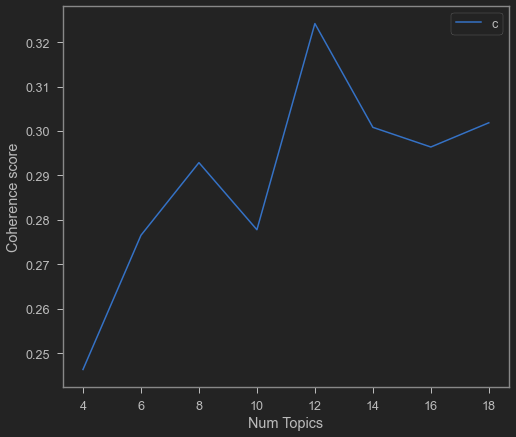

In [21]:
# Show graph
limit=20; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))

Num Topics = 4  has Coherence Value of 0.25
Num Topics = 6  has Coherence Value of 0.28
Num Topics = 8  has Coherence Value of 0.29
Num Topics = 10  has Coherence Value of 0.28
Num Topics = 12  has Coherence Value of 0.32
Num Topics = 14  has Coherence Value of 0.3
Num Topics = 16  has Coherence Value of 0.3
Num Topics = 18  has Coherence Value of 0.3


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.039*"no" + 0.020*"saber" + 0.017*"tener" + 0.013*"si" + '
  '0.012*"salvadoreño" + 0.010*"hacer" + 0.009*"venezolano" + 0.008*"mierda" + '
  '0.007*"pobre" + 0.007*"defender"'),
 (1,
  '0.027*"no" + 0.019*"maldito" + 0.017*"salvadoreño" + 0.014*"decir" + '
  '0.012*"dejar" + 0.011*"si" + 0.010*"mejor" + 0.010*"nicaragua" + '
  '0.010*"robar" + 0.010*"pobre"'),
 (2,
  '0.047*"no" + 0.015*"nicaragua" + 0.014*"llevar" + 0.013*"tener" + '
  '0.011*"venezolano" + 0.010*"salvadoreño" + 0.009*"seguir" + 0.008*"decir" + '
  '0.007*"hacer" + 0.007*"así"'),
 (3,
  '0.021*"tener" + 0.020*"mierda" + 0.019*"no" + 0.017*"salvadoreño" + '
  '0.014*"pobre" + 0.013*"hacer" + 0.012*"si" + 0.009*"dejar" + '
  '0.008*"guanaco" + 0.007*"salvador"'),
 (4,
  '0.043*"no" + 0.026*"salvadoreño" + 0.017*"si" + 0.016*"mierda" + '
  '0.013*"puta" + 0.013*"hacer" + 0.011*"solo" + 0.010*"venezolano" + '
  '0.009*"querer" + 0.008*"robar"'),
 (5,
  '0.040*"no" + 0.025*"tener" + 0.019*"salvadoreño" + 0.016*"n

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
visx = pyLDAvis.gensim.prepare(topic_model=optimal_model, corpus=corpus, dictionary=dictionary, mds='mmds')
pyLDAvis.display(visx)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\JOSE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning,

In [25]:
# Archivo HTML
pyLDAvis.save_html(visx, 'ldax2.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 540/540 [2:43:15<00:00, 18.14s/it]  


In [27]:
tabla_tunning = pd.read_csv('lda_tuning_results.csv')
tabla_tunning = tabla_tunning.sort_values(by = 'Coherence')
tabla_tunning

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.214705
3,75% Corpus,2,0.01,0.9099999999999999,0.218756
32,75% Corpus,3,0.01,0.61,0.221370
13,75% Corpus,2,0.61,0.9099999999999999,0.221668
23,75% Corpus,2,symmetric,0.9099999999999999,0.221668
...,...,...,...,...,...
418,100% Corpus,6,asymmetric,0.9099999999999999,0.477545
357,100% Corpus,4,asymmetric,0.61,0.482859
268,75% Corpus,10,asymmetric,0.9099999999999999,0.496896
178,75% Corpus,7,asymmetric,0.9099999999999999,0.514126


In [28]:
tabla_tunning.to_excel('mejor_modelo.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:


#corpus = corpora.MmCorpus('tweets_x.mm')
#dictionary = corpora.Dictionary('tweets_x.dict')
# EL mejor modelo
eta = 0.9099999999999999
lda_final_model = gensim.models.LdaMulticore(corpus=mm,
                                             id2word=dictionary,
                                             num_topics=4,
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha='asymmetric',
                                             eta=eta)

[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

pprint(lda_final_model.print_topics())
doc_lda = lda_final_model[corpus]

visxx = pyLDAvis.gensim.prepare(topic_model=lda_final_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.display(visxx)


C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\JOSE\anaconda3\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


[(0,
  '0.028*"no" + 0.013*"salvadoreño" + 0.012*"tener" + 0.010*"mierda" + '
  '0.008*"si" + 0.008*"nicaragua" + 0.007*"hacer" + 0.007*"venezolano" + '
  '0.006*"decir" + 0.006*"pobre"'),
 (1,
  '0.005*"nicaragua" + 0.003*"pobre" + 0.002*"no" + 0.002*"venezolano" + '
  '0.002*"parte" + 0.002*"casa" + 0.002*"venezuela" + 0.001*"hacer" + '
  '0.001*"seguir" + 0.001*"salvadoreño"'),
 (2,
  '0.001*"puto" + 0.001*"chupar" + 0.001*"presidente" + 0.001*"nicaragua" + '
  '0.001*"llevar" + 0.001*"imponer" + 0.001*"selección" + 0.001*"víctor" + '
  '0.001*"quemar" + 0.001*"habla"'),
 (3,
  '0.001*"aquel" + 0.001*"mente" + 0.001*"jajajajjaja" + 0.001*"cochino" + '
  '0.001*"consumo" + 0.001*"no" + 0.001*"ver" + 0.001*"nicaragua" + '
  '0.001*"tener" + 0.001*"venir"')]


In [30]:
pyLDAvis.save_html(visxx, 'ldax3.html')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_final_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_final_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.845977189600991

Coherence Score:  0.389451225357576


# Finding the dominant topic in each sentence

In [32]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_final_model, corpus=corpus, texts=df['Snippet'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9635,"no, salvadoreño, tener, mierda, si, nicaragua,...",Por pendejadas diría yo... Bien decía el prof...
1,1,0.0,0.9741,"no, salvadoreño, tener, mierda, si, nicaragua,...","...empleos perdidos, los pobres más pobres aú..."
2,2,0.0,0.9669,"no, salvadoreño, tener, mierda, si, nicaragua,...",Todavía hay pendejos discutiendo la venezolane...
3,3,0.0,0.8945,"no, salvadoreño, tener, mierda, si, nicaragua,...",Que putas está pasando?!?? 🤯🤯🤯 esto no puede...
4,4,1.0,0.5628,"nicaragua, pobre, no, venezolano, parte, casa,...",No hay transformación posible si estas élites ...
5,5,0.0,0.9188,"no, salvadoreño, tener, mierda, si, nicaragua,...","asesinada.\nEn este sentido, el mandatario sal..."
6,6,0.0,0.9521,"no, salvadoreño, tener, mierda, si, nicaragua,...",Malditos... Exijamos a AMLO una respuesta en...
7,7,0.0,0.9584,"no, salvadoreño, tener, mierda, si, nicaragua,...","Cara Sucia, yo aprendí a ver novelas con mi a..."
8,8,0.0,0.9767,"no, salvadoreño, tener, mierda, si, nicaragua,...","Dicho esto, Alianza es el equipo que mejor p..."
9,9,0.0,0.9728,"no, salvadoreño, tener, mierda, si, nicaragua,...",Hubo una época en la que el Pájaro Picón Picón...


In [33]:
df_dominant_topic.to_excel('Topico_dominante_por_frase_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Find the most representative document for each topic

In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9814,"no, salvadoreño, tener, mierda, si, nicaragua,...","Fui yo, pero para reunirme contigo, una asque..."
1,1.0,0.9737,"nicaragua, pobre, no, venezolano, parte, casa,...","Dice el Presi que ya les van a caer los Q1,..."
2,2.0,0.9467,"puto, chupar, presidente, nicaragua, llevar, i...",RT Que alguien le explique a este INCOMPETE...
3,3.0,0.9022,"aquel, mente, jajajajjaja, cochino, consumo, n...",al parcer me equivoque copiando una foto de go...


In [35]:
sent_topics_sorteddf_mallet.to_excel('tweets_representativos_por_topico_snippet.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic distribution across documents

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",948.0,0.9029
1.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",80.0,0.0762
2.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",19.0,0.0181
3.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",3.0,0.0029
4.0,1.0,"nicaragua, pobre, no, venezolano, parte, casa,...",NaN,NaN
...,...,...,...,...
1045.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",NaN,NaN
1046.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",NaN,NaN
1047.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",NaN,NaN
1048.0,0.0,"no, salvadoreño, tener, mierda, si, nicaragua,...",NaN,NaN


In [37]:
df_dominant_topics.to_excel('distribución_de_topicos_a_traves_de_documentos.xlsx')

C:\Users\JOSE\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
